<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Exploratory Data Analysis on a Natural Language Processing Task

---

Exploratory data analysis (EDA) is a crucial part of any data science project. EDA helps us discover interesting relationships in the data, detect outliers and errors, examine our own assumptions about the data, and prepare for modeling. During EDA we might discover that we need to clean our data more conscientiously, or that we have more missing data than we realized, or that there aren't many patterns in the data (indicating that modeling may be challenging.)

In this lab you'll bring in a natural language dataset and perform EDA. The dataset contains Facebook statuses taken from between 2009 and 2011 as well as personality test results associated with the users whose Facebook statuses are included.

This dataset uses results from the Big Five Personality Test, also referred to as the five-factor model, which measures a person's score on five dimensions of personality:
- **O**penness
- **C**onscientiousness
- **E**xtroversion
- **A**greeableness
- **N**euroticism

Notoriously, the political consulting group Cambridge Analytica claims to have predicted the personalities of Facebook users by using those users' data, with the goal of targeting them with political ads that would be particularly persuasive given their personality type. Cambridge Analytica claims to have considered 32 unique 'groups' in the following fashion:
- For each of the five OCEAN qualities, a user is categorized as either 'yes' or 'no'.
- This makes for 32 different potential combinations of qualities. ($2^5 = 32$).

Cambridge Analytica's methodology was then, roughly, the following:
- Gather a large amount of data from Facebook.
- Use this data to predict an individual's Big Five personality "grouping."
- Design political advertisements that would be particularly effective to that particular "grouping." (For example, are certain advertisements particularly effective toward people with specific personality traits?)

In this lab you will perform EDA to examine many relationships in the data.

Exploratory data analysis can be a non-linear process, and you're encouraged to explore questions that occur to you as you work through the notebook.

> **Content note**: This dataset contains real Facebook statuses scraped from 2009 to 2011, and some of the statuses contain language that is not safe for work, crude, or offensive. The full dataset is available as `mypersonality.csv`, and a sanitized version containing only statuses that passed an automated profanity check is available as `mypersonality_noprofanity.csv`. Please do not hesitate to use `mypersonality_noprofanity.csv` if you would prefer to. Please note that the automated profanity check is not foolproof. If you have any concerns about working with this dataset, please get in touch with your instructional team.

---

### External resources

These resources are not required reading but may be of use or interest.

- [**Python Graph Gallery**](https://python-graph-gallery.com/)
- [**Wikipedia page**](https://en.wikipedia.org/wiki/Big_Five_personality_traits) on the Big Five test
- [**A short (3-4 pages) academic paper**](./celli-al_wcpr13.pdf) using the `MyPersonality` dataset to model personality

---

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#!pip install nltk

from sklearn.feature_extraction.text import CountVectorizer

# This setting widens how many characters 
# pandas will display in a column
pd.options.display.max_colwidth = 400

# distplots from Seaborn are still awesome
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

---

## Load data

In [4]:
df = pd.read_csv('data/mypersonality.csv')

# NOTICE! Do read the commented out code below...

# df = pd.read_csv('data/mypersonality_noprofanity.csv') 
# comment out above & 
# uncomment this to use mypersonality_noprofanity.csv if it 
# makes you more comfortable

df.drop(columns=['NETWORKSIZE', 'BETWEENNESS', 'NBETWEENNESS', 
                 'DENSITY', 'BROKERAGE', 'NBROKERAGE', 
                 'TRANSITIVITY'], inplace=True)
df.head(3)

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she can't get to sleep.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/02/09 08:41 AM
2,b7b7764cfa1c523e4e93ab2a79a946c4,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/15/09 01:15 PM


---

## EDA on Statuses

Before we even vectorize the text, we might look at the lengths and word counts in each Facebook status.

**Create a new column called `status_length` that contains the length of each status:**

In [6]:
# Create a new column for the length of each status
df['status_length'] = df['STATUS'].apply(len)
df[['STATUS', 'status_length']].head()

,STATUS,status_length
0,likes the sound of thunder.,27
1,is so sleepy it's not even funny that's she can't get to sleep.,63
2,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",121
3,likes how the day sounds in this new song.,42
4,is home. <3,11


**Create a new column called `status_word_count` that contains the number of words in each status:**

Note: You can evaluate this based off of how many strings are separated by whitespaces; you're not required to check that each set of characters set apart by whitespaces is a word in the dictionary.

In [8]:
# Create a new column for word count
df['status_word_count'] = df['STATUS'].apply(lambda x: len(x.split()))
df[['STATUS', 'status_word_count']].head()

,STATUS,status_word_count
0,likes the sound of thunder.,5
1,is so sleepy it's not even funny that's she can't get to sleep.,13
2,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",26
3,likes how the day sounds in this new song.,9
4,is home. <3,3


### Longest and shortest statuses

Looking at individual observations can help us get a sense of what the dataset contains.

**Show the five longest and five shortest statuses based off of `status_word_count`:**

In [10]:
# Five longest statuses
df.nlargest(5, 'status_word_count')[['STATUS','status_word_count']]

,STATUS,status_word_count
496,"Exact words when renewing DL: Me: Oh no, you can't take my license, It's my 25th b-day. How am I going to get into the bar? DMV: We gonna give you a new one over there Me: But, it won't have my picture and stuff on it. Dmv: Hold up, we can take a picture of your picture and put it on a license i think. (yelling at co-worker to see if this can be done) Yup! Me: So, I can go to the bar?! Dmv: ...",89
6989,"If I wear makeup, I'm fake. If I like to get dressed up, I'm a Tart. If I say what i think, I'm a bitch. If I cry sometimes, I'm a drama queen. If I have guy friends, I'm a slut. If I stand up for myself, I'm mouthy. Seems like you can't do anything now a days without being labeled.. So what, go ahead and label me, see if i give a shit. Repost this if your proud of who you are! x x",85
5208,"can't believe it. I got the new Wii Fit Plus game, it has a lot of fun new games and features. However, after not using the wii fit for a few months we decided to do the fitness test stuff again. Me(since last time): +2.9 lbs, still a healthy weight and BMI, wii age 54. *PROPNAME*: -8.6lbs, reccommends a healthy weight of gaining 6lbs, wii age 32. On the positive side, I have lost 5 of the 8 l...",84
4665,"worst night ever! then I get this message? ""hey so i just moved up here and ill be honest, living with someone but not getting needs met sexually and hoping to find someone in same position or at least who understands and can be discrete, if you may be interested let me know ,if not i am very sorry to have bothered you"" I could be a god damn serial killer who gets off setting people on fire ur...",83
5680,"I always make it a rule to let the other fellow fire first. If a man wants to fight, I argue the question with him and try to show him how foolish it would be. If he can't be dissuaded, why then the fun begins but I always let him have first crack. Then when I fire, you see, I have the verdict of self-defence on my side. I know that he is pretty certain in his hurry, to miss. I never do.",83


In [11]:
# Five shortest statuses
df.nsmallest(5, 'status_word_count')[['STATUS','status_word_count']]

,STATUS,status_word_count
5,www.thejokerblogs.com,1
26,<3,1
144,ARGGGGGGGGGGGGG!!!!!!!,1
200,:)))))))),1
221,SNOW!!!,1


## What's the distribution of post lengths?

Use visuals to show the distributions of post lengths. Show both the distribution of word counts and the distribution of lengths based off character.

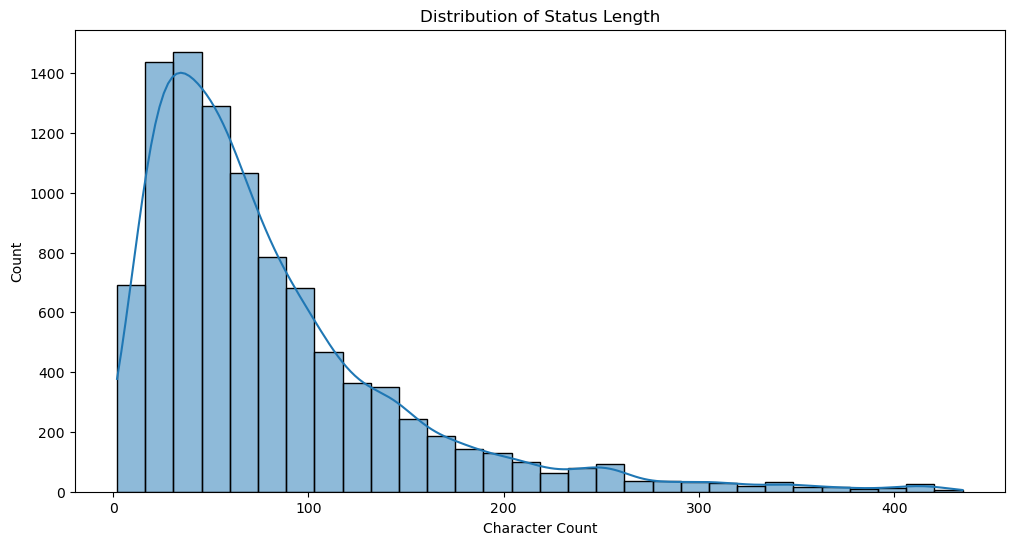

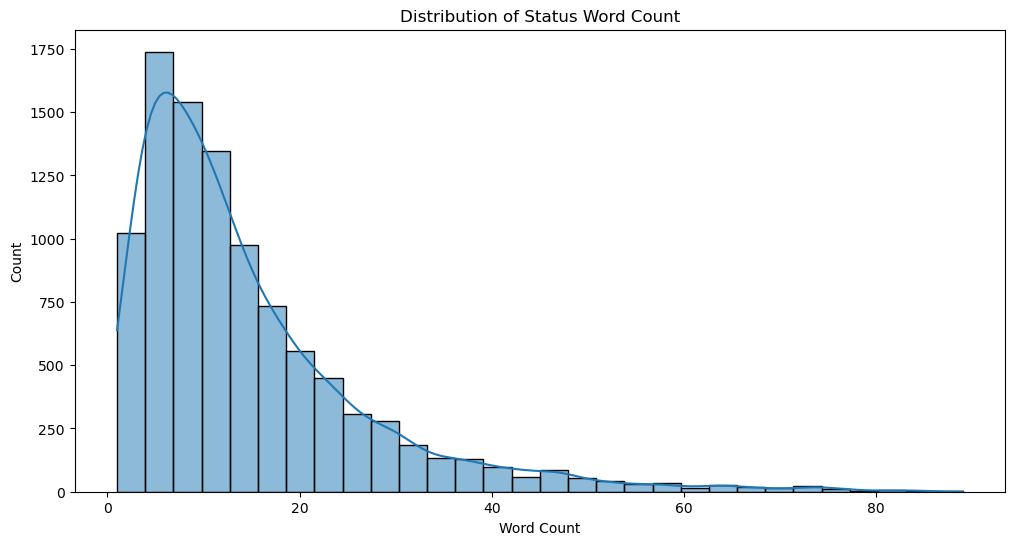

In [13]:
# Distribution of status length
plt.figure(figsize=(12, 6))
sns.histplot(df['status_length'], bins=30, kde=True)
plt.title('Distribution of Status Length')
plt.xlabel('Character Count')
plt.show()

# Distribution of status word count
plt.figure(figsize=(12, 6))
sns.histplot(df['status_word_count'], bins=30, kde=True)
plt.title('Distribution of Status Word Count')
plt.xlabel('Word Count')
plt.show()

---

## EDA of Personality Scores

There are two sets of personality columns in the dataset: class and score. According to the attached paper, scores have been converted to categories based on whether a score for a user fell above or below the median.

### Plot the distributions of personality scores for all five score columns:

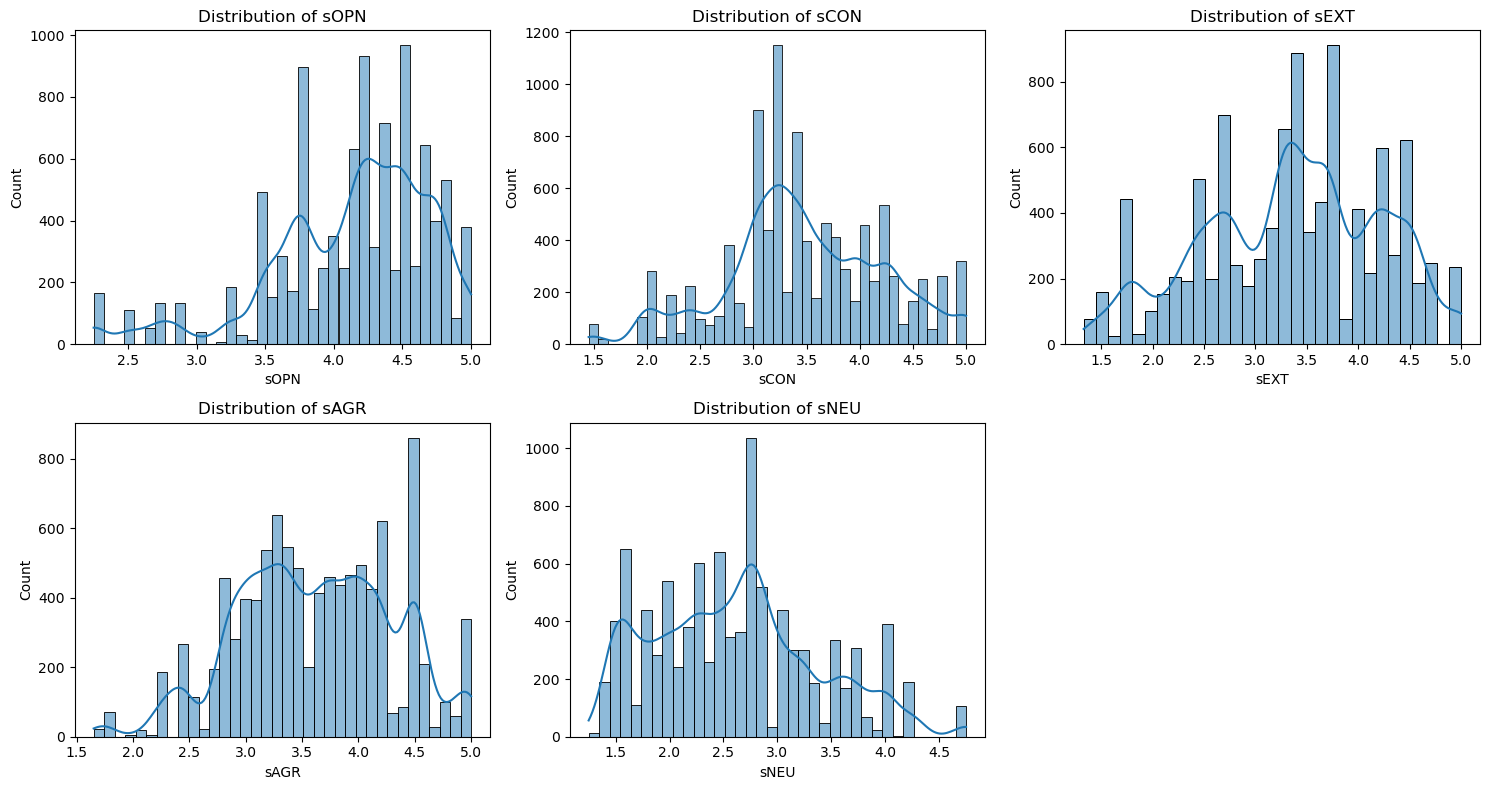

In [15]:
# Plotting distributions for each personality score column
personality_scores = ['sOPN', 'sCON', 'sEXT', 'sAGR', 'sNEU']

plt.figure(figsize=(15, 8))

for i, trait in enumerate(personality_scores, 1): # enumerate = 1 i start index from 1
    plt.subplot(2, 3, i)
    sns.histplot(df[trait], kde=True) #Add line
    plt.title(f'Distribution of {trait}')
plt.tight_layout()
plt.show()

---

### How many unique users exist in the dataset?

This dataset has redacted original poster names, but each user is given an `#AUTHID`. How many unique users are there, and how many posts per user do we have?

In [17]:
# Number of unique users
unique_users = df['#AUTHID'].nunique()
print(f'Number of unique users: {unique_users}')

# Average posts per user
posts_per_user = df['#AUTHID'].value_counts().mean().round(2)
print(f'Average number of posts per user: {posts_per_user}')

Number of unique users: 250
Average number of posts per user: 39.66


## EDA on unique users

Because we have many posts per user for most users, doing EDA on the personality score columns might be misleading. If we have 200 Facebook statuses from one very high-conscientiousness user, a bar chart of how many `'cCON'` statuses are associated with `'y'` might be misleading. We'll have to be careful about labeling and titling any visualizations we make off of the dataset.

**Create a new dataframe called `unique_users` that only contains the `#AUTHID`, personality score, and personality category columns:**

If you do this correctly, it should have 250 rows and 11 columns.

(Hint: You can use the pandas [**drop_duplicates()**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html) method to make this easier. The only column you want to consider when deciding if a user is duplicated is the `#AUTHID` column.)

In [19]:
df.columns

Index(['#AUTHID', 'STATUS', 'sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN', 'cEXT',
       'cNEU', 'cAGR', 'cCON', 'cOPN', 'DATE', 'status_length',
       'status_word_count'],
      dtype='object')

In [20]:
# Select only the necessary columns
unique_users = df.drop(['STATUS', 'DATE', 'status_length', 'status_word_count'], axis=1)

# Drop duplicate users based on '#AUTHID'
unique_users = unique_users.drop_duplicates(subset=['#AUTHID'])

# Check the shape to confirm it has 250 rows and 11 columns
print(f'unique_users DataFrame shape: {unique_users.shape}') #Check wether have correct shape, it should have 250 rows and 11 columns.

unique_users DataFrame shape: (250, 11)


In [21]:
unique_users.columns # Check work

Index(['#AUTHID', 'sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN', 'cEXT', 'cNEU',
       'cAGR', 'cCON', 'cOPN'],
      dtype='object')

**Plot the distribution of personality scores for `unique_users`:**

Do the distributions look different? Here, each individual user will only be represented once.

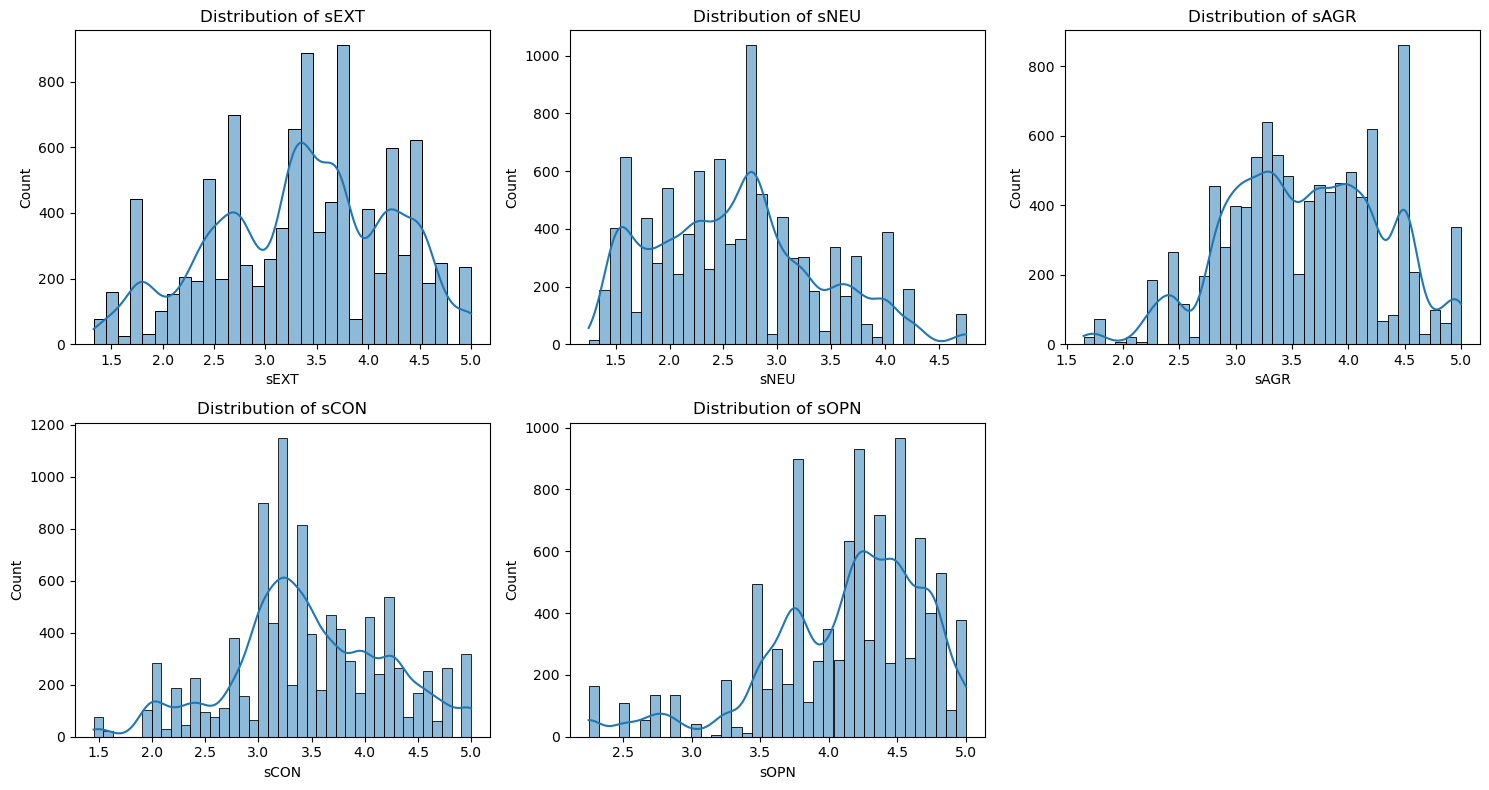

In [23]:
# Plotting distributions for each personality score column
personality_scores_unique = unique_users[['sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN']]

plt.figure(figsize=(15, 8))

for i, trait in enumerate(personality_scores_unique, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[trait], kde=True)
    plt.title(f'Distribution of {trait}')
plt.tight_layout()
plt.show()

**Use the `.describe()` method on `unique_users`:**

In [25]:
unique_users.describe()

,sEXT,sNEU,sAGR,sCON,sOPN
count,250.000000,250.000000,250.000000,250.000000,250.00000
mean,3.292120,2.627240,3.600320,3.522920,4.07856
std,0.861368,0.776835,0.670758,0.740211,0.57506
min,1.330000,1.250000,1.650000,1.450000,2.25000
25%,2.662500,2.000000,3.150000,3.000000,3.75000
50%,3.300000,2.590000,3.660000,3.500000,4.15000
75%,4.000000,3.150000,4.100000,4.050000,4.50000
max,5.000000,4.750000,5.000000,5.000000,5.00000


### Plots vs. Tables

Consider what different information is easily conveyed by the plots of scores, versus the table with summary statistics. Explain when you might present a distribution versus when you might present a table of summary statistics.

In [27]:
# Use plots when want to visually communicate trends, patterns, and the distribution of data, 
# or when exploring how different values relate to each other in a more intuitive way.

# Use tables when need to provide detailed, specific numerical information 
# or when presenting exact statistics like mean, median, standard deviation, or things that require precision.

#### Other visualizations:

Create at least 2 additional visualizations related to the `unique_users` dataframe.

You might consider:
- Bar charts of users per category per trait
- Seaborn correlation heatmap
- Seaborn pairplot

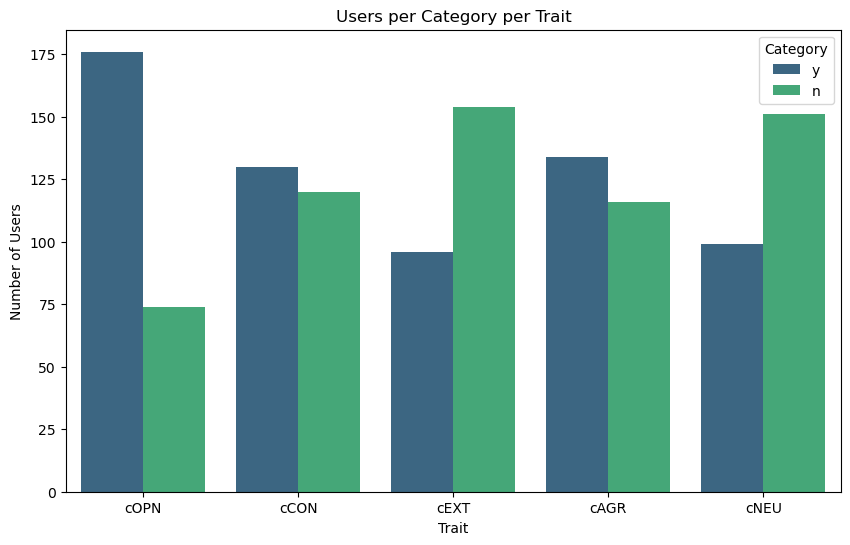

In [44]:
# Melt the dataframe to reshape it for easier plotting
plotting_count_trait = unique_users.melt(id_vars=['#AUTHID'], value_vars=['cOPN', 'cCON', 'cEXT', 'cAGR', 'cNEU'], 
                              var_name='Trait', value_name='Category')

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.countplot(data=plotting_count_trait, x='Trait', hue='Category', palette='viridis')
plt.title('Users per Category per Trait')
plt.xlabel('Trait')
plt.ylabel('Number of Users')
plt.show()

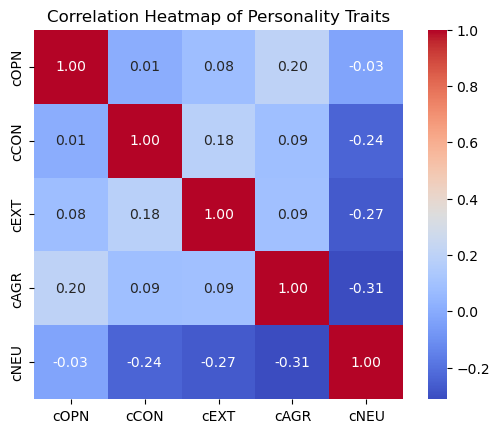

In [48]:
# Calculate and plot the correlation matrix for personality traits
sns.heatmap(unique_users[['cOPN', 'cCON', 'cEXT', 'cAGR', 'cNEU']].apply(lambda x: x == 'y').astype(int).corr(), 
            annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Heatmap of Personality Traits')
plt.show()

---

## Exploring status length and word count based on personality

**Using `groupby()`, find the mean status length and status word count for posts by users in the high and low categories of each of the Big 5 traits.**

You'll need to use `groupby()` five separate times for this.

**Choose one of the personality category columns (i.e. `cOPN`, `cCON`, `cEXT`, `cAGR`, or `cNEU`.) Use `sns.distplot()` to visualize the distribution of status word counts for posts by users who score both high (`y`) and low (`n`) in that personality category:**

In [52]:
df.columns

Index(['#AUTHID', 'STATUS', 'sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN', 'cEXT',
       'cNEU', 'cAGR', 'cCON', 'cOPN', 'DATE', 'status_length',
       'status_word_count'],
      dtype='object')

In [58]:
df[['cEXT','status_length', 'status_word_count']].groupby('cEXT').mean()

,status_length,status_word_count
cEXT,,
n,79.866655,14.394428
y,81.704918,14.702305


In [60]:
df[['cNEU','status_length', 'status_word_count']].groupby('cNEU').mean()

,status_length,status_word_count
cNEU,,
n,80.852396,14.548314
y,80.304278,14.486414


In [62]:
df[['cAGR','status_length', 'status_word_count']].groupby('cAGR').mean()

,status_length,status_word_count
cAGR,,
n,80.976769,14.616692
y,80.355800,14.444276


In [64]:
df[['cCON','status_length', 'status_word_count']].groupby('cCON').mean()

,status_length,status_word_count
cCON,,
n,81.920149,14.709515
y,79.149034,14.308165


---

## EDA on Word Counts

### Vectorize the text

In order to perform EDA on word count data, we'll need to count vectorize.

Create a dataframe that contains the count-vectorized text for each Facebook status in the dataset.

To do this, you might follow these steps:
- Instantiate a `CountVectorizer` object
- Fit the count vectorizer on the Facebook statuses
- Store the transformed data
- Convert to a dataframe and store
    - Don't forget that the transformed data will need to be 'densified'. The `toarray()` or `todense()` methods will allow this.
    - Don't forget that the `get_feature_names_out()` method on a fitted `CountVectorizer` object will bring you back the words learned from the dataset, which you can set as the `columns` argument when creating the dataframe.
    
It's up to you whether or not to keep stopwords in the dataset.

### Show the 15 most common words

In [72]:
# Import lib
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer and fit on STATUS column
vectorizer = CountVectorizer(stop_words='english')
status_counts = vectorizer.fit_transform(df['STATUS'])

# Convert to DataFrame for easy handling
status_counts_df = pd.DataFrame(status_counts.toarray(), columns=vectorizer.get_feature_names_out())

# Sum up word counts and display the 15 most common words
top_words = status_counts_df.sum().sort_values(ascending=False).head(15)
print("Top 15 most common words:\n", top_words) # Use \n for easier display

Top 15 most common words:
 propname    1309
just         717
day          534
like         506
time         424
going        414
today        402
new          386
work         369
good         354
got          314
night        312
love         292
tomorrow     277
know         276
dtype: int64


### Show the 15 frequency of the most common words as a bar chart

**Hint**: You can do this in one line of code. [This webpage](https://dfrieds.com/data-visualizations/bar-plot-python-pandas.html) has an example.

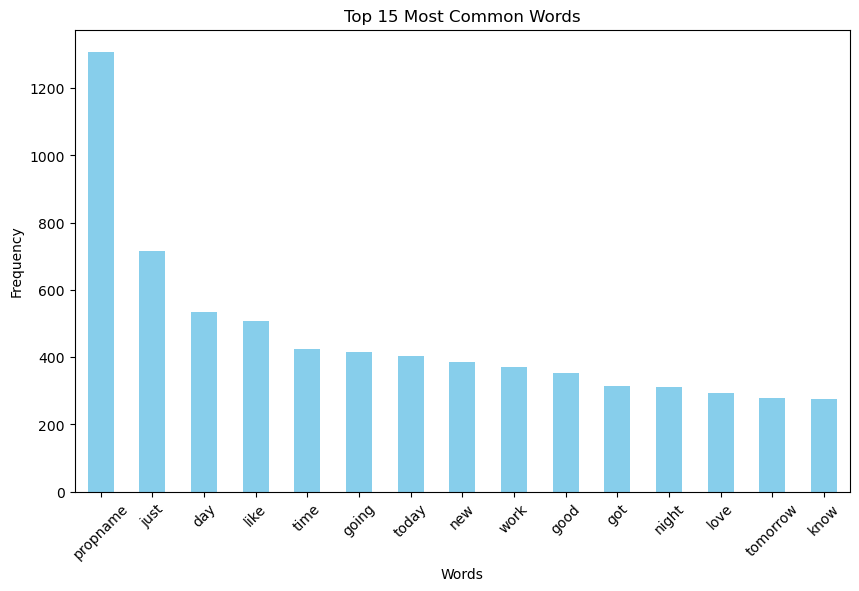

In [74]:
# Plotting top 15 words
plt.figure(figsize=(10, 6))
top_words.plot(kind='bar', color='skyblue')
plt.title("Top 15 Most Common Words")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

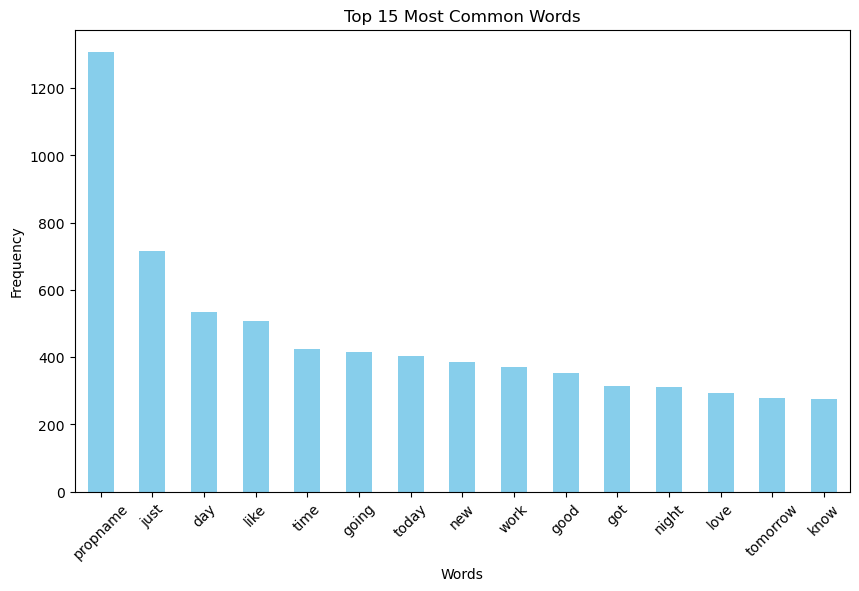

In [76]:
# TRY to do in one line
top_words.plot(kind='bar', color='skyblue', figsize=(10, 6), title="Top 15 Most Common Words", xlabel="Words", ylabel="Frequency", rot=45)
plt.show()

### Investigating `propname`

The word `propname` shows up frequently in this dataset. Show the first 10 statuses in the dataset that contain `propname`:

In [78]:
# Directly filter and display the first 10 statuses containing 'propname'
print(df[df['STATUS'].str.contains('propname', na=False, case=False)].head(10)['STATUS']) #ignore NaN and no need to care case

6                                                                                                                                                                                                                                                         saw a nun zombie, and liked it. Also, *PROPNAME* + Tentacle!Man + Psychic Powers = GREAT Party.
18                                                                                                                                                                                                                                                                                                         is tired. *PROPNAME*, let me go to sleep pl0x.
69                                                                                                                                                                                                              has a fair idea of how to manage the 2.5 kids cliche... She just needs a very strong gentleman named

**Provide a short explanation of what you believe `propname` to be:**

In [80]:
# Seems to be name of somthing like people or pet
# e.g. 
# - She just needs a very strong gentleman named *PROPNAME* and thriteen wet napkins.
# - is in love with *PROPNAME*
# - Vote for the short "AFTER HOURS" to support *PROPNAME*

## Most common words based on personality category

In order to do more targeted EDA, we'll need to be able to reference not only the dataframe of vectorized statuses, but also the personality scores from the original dataframe.

**Create a new dataframe called `text_and_scores` that concatenates the count-vectorized statuses side-by-side with the original personality category columns:**

In [86]:
# Creat personality category columns directly from the DataFrame
personality_category = df[['cOPN', 'cCON', 'cEXT', 'cAGR', 'cNEU']]

# Concatenate the vectorized statuses (I set as 'status_count_df' earlier) with the personality category side-by-side
text_and_scores = pd.concat([status_counts_df, personality_category], axis=1)
text_and_scores

,00,000,000ft,00am,00pm,01,02,02pm,03,0330,...,été,être,østersund,últimas,últimos,cOPN,cCON,cEXT,cAGR,cNEU
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,y,n,n,n,y
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,y,n,n,n,y
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,y,n,n,n,y
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,y,n,n,n,y
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,y,n,n,n,y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9911,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,y,n,n,y,n
9912,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,y,y,y,y,y
9913,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,y,y,y,y,y
9914,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,y,n,n,n,y


**Show the 25 most common words for statuses from high-cAGR users:**

In [ ]:
# high (`y`) and low (`n`)

In [88]:
# Display the 25 most common words for high-cAGR users 
print(
    text_and_scores[text_and_scores['cAGR'] == 'y']  # Filter for high-cAGR users with 'y'
    .drop(columns=['cOPN', 'cCON', 'cEXT', 'cAGR', 'cNEU'])  # Drop personality columns
    .sum()  # Sum the word counts
    .nlargest(25))  # Get the top 25 most common words


propname    699
just        402
day         297
like        280
time        221
today       219
work        206
good        201
going       200
new         194
love        172
happy       165
night       161
got         157
know        157
people      156
tomorrow    153
life        140
home        131
tonight     129
really      127
don         119
want        108
weekend     105
ll          103
dtype: int64


**Show the 25 most common words for statuses from low-cAGR users:**

In [91]:
# Display the 25 most common words for statuses from low-cAGR users:
print(
    text_and_scores[text_and_scores['cAGR'] == 'n']  # Filter for low-cAGR users with 'n'
    .drop(columns=['cOPN', 'cCON', 'cEXT', 'cAGR', 'cNEU'])  # Drop personality columns
    .sum()  # Sum the word counts
    .nlargest(25))  # Get the 25 most common words for statuses from low-cAGR users:

propname    610
just        315
day         237
like        226
going       214
time        203
new         192
today       183
work        163
got         157
good        153
night       151
home        136
don         134
tonight     127
tomorrow    124
life        120
love        120
know        119
really      119
people      112
think       110
want        109
happy       107
week         98
dtype: int64


### Most common bigrams:

Find the 10 most common [**bigrams**](https://en.wikipedia.org/wiki/Bigram) in the dataset.

In [97]:
# Initialize CountVectorizer and fit on STATUS column
bi_vectorizer = CountVectorizer(analyzer='word',stop_words='english',ngram_range=(2,2))
#Fit
bi_cvec = bi_vectorizer.fit_transform(df['STATUS'])
# get_feature_names_out and make DataFrame
bi_cvec_df = pd.DataFrame(bi_cvec.toarray(), columns=bi_vectorizer.get_feature_names_out())

In [99]:
print (bi_cvec_df.sum().sort_values(ascending=False).head(10)) # Get the result out

propname propname    147
just got              55
new year              53
http www              46
merry christmas       44
looking forward       43
feel like             39
happy new             32
don know              31
birthday wishes       29
dtype: int64


### Most common trigrams:

Find the 10 most common [**trigrams**](https://en.wikipedia.org/wiki/Trigram) in the dataset.

In [101]:
# Initialize CountVectorizer and fit on STATUS column
tri_vectorizer = CountVectorizer(analyzer='word',stop_words='english',ngram_range=(3,3))

#Fit
tri_cvec = tri_vectorizer.fit_transform(df['STATUS'])

# get_feature_names_out and convert to DataFrame 
tri_cvec_df = pd.DataFrame(tri_cvec.toarray(), columns=tri_vectorizer.get_feature_names_out())

In [102]:
print (tri_cvec_df.sum().sort_values(ascending=False).head(10)) # Get the result out

propname propname propname    54
gainesville film industry     23
www examiner com              23
http www examiner             23
24676 gainesville film        23
film industry examiner        23
happy new year                21
examiner com examiner         20
com examiner 24676            20
examiner 24676 gainesville    20
dtype: int64


---

## Choose your own adventure

By now you've looked at a lot of visualizations and frequency counts.

Come up with 2-3 questions about the data, and try to answer them using descriptive statistics (like counts, averages, etc.) or visualizations.

Some questions you might explore:
- Have numbers been redacted, or are phone numbers, house numbers, or zip codes anywhere in the dataset?
- `PROPNAME` has been used to redact personal names. Given that this data was scraped between 2009 and 2011, investigate if any public figures or famous people show up in the dataset, or their names have been redacted as well.
- Is count of uppercase letters vs. lowercase letters per status related to any personality category or personality score?
- Is _average_ word count per status related to any personality category or personality metric?
- Is punctuation use related to personality?

Or, of course, come up with your own questions to investigate!

The focus here is on "explore" -- you might not find anything of particular interest, but don't let that discourage you.

In [105]:
# Q: Do people with openess post status longer then those without?
# A: People with openness (cOPN = y: 78.9) post shorter statuses, on average, compared to those without openness (cOPN = n: 85.6) 

df[['cOPN','status_length', 'status_word_count']].groupby('cOPN').describe().T

cOPN                               n            y
status_length     count  2547.000000  7369.000000
                  mean     85.686298    78.905143
                  std      75.661805    65.398611
                  min       2.000000     2.000000
                  25%      35.000000    34.000000
                  50%      62.000000    60.000000
                  75%     109.000000   102.000000
                  max     435.000000   426.000000
status_word_count count  2547.000000  7369.000000
                  mean     15.450726    14.205184
                  std      13.697532    11.991796
                  min       1.000000     1.000000
                  25%       6.000000     6.000000
                  50%      11.000000    11.000000
                  75%      20.000000    18.000000
                  max      84.000000    89.000000

In [107]:
# Q: Are people with cOPN = y more likely to have other traits (cEXT, cNEU, cAGR, cCON) as y?
# A: Openness appears to have a moderate to strong association with agreeableness  (cAGR)
#    Weaker association with conscientiousness, extroversion, and neuroticism.

for trait in ['cEXT', 'cNEU', 'cAGR', 'cCON']:
    percent = (df[df['cOPN'] == 'y'][trait] == 'y').mean() * 100
    print(f"Percentage of 'y' in {trait} for cOPN = 'y': {percent:.2f}%")

Percentage of 'y' in cEXT for cOPN = 'y': 43.78%
Percentage of 'y' in cNEU for cOPN = 'y': 34.41%
Percentage of 'y' in cAGR for cOPN = 'y': 63.36%
Percentage of 'y' in cCON for cOPN = 'y': 43.72%


---

## Exploratory vs. Explanatory Data Analysis 

> **Exploratory analysis** is what you do to get familiar with the data. You may start out with a hypothesis or question, or you may just really be delving into the data to determine what might be interesting about it. Exploratory analysis is the process of turning over 100 rocks to find perhaps 1 or 2 precious gemstones.
>
> **Explanatory analysis** is what happens when you have something specific you want to show an audience - probably about those 1 or 2 precious gemstones. In my blogging and writing, I tend to focus mostly on this latter piece, explanatory analysis, when you've already gone through the exploratory analysis and from this have determined something specific you want to communicate to a given audience: in other words, when you want to tell a story with data.

- Cole Nussbaumer Knaflic, [**exploratory vs. explanatory analysis**](http://www.storytellingwithdata.com/blog/2014/04/exploratory-vs-explanatory-analysis)

### Choose one visual to explain:

Now that you've performed an exploratory data analysis, choose a visual (or 1-3 related visuals) to frame as **_explanatory_**. This can be a visual you created above, or you can create a new visual. For this visual, make sure the visuals are formatted clearly, and provide a one to two paragraph explanation/interpretation of the visual.